# Filter in frequency domain
CCD provides a 128 bin magnitude response of the filter. Transfer a chunck of audio into frequency domain, multiply with magnitude response, then transform back in time domain.

Use FFT and overlap save method for efficient processing.

Siumulate CCD data by sweeping over an image. Apply filter to audio file and play it.

Works but still sounds choppy.

In [1]:
%pylab notebook
from PIL import Image
import soundfile as sf
import pygame
from time import sleep

def getChunk(arr, bSize=256, overlap=0):
    """
        Yield chunks of `add` with overlap for overlap save method.
        bSize = how many samples are consumed per block
        overlap = how many additional old samples shall be added to the end
    """
    nRows = int(ceil(arr.size / bSize)) + 1
    mat = resize(arr, (nRows, bSize))
    mat.ravel()[arr.size:] = 0
    scratch = zeros(overlap, dtype=arr.dtype)
    for c in mat:
        yield hstack((scratch, c))
        scratch[:] = c[-overlap:]

Populating the interactive namespace from numpy and matplotlib
pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


# Overlap save test
with different FFT lengths

According to
http://blog.robertelder.org/overlap-add-overlap-save/

In [2]:
testDat = array([3, -1, 0, 3, 2, 0, 1, 2, 1])
h_t = array([1, -1, 1])

#---------------------------
# Overlap save parameters
#---------------------------
M = len(h_t)   # Length of repsonse
O = M - 1      # Overlap
N = 8          # FFT length (adjustable)
L = N - O      # Consumed samples per iteration

print(M, O, N, L)

res = list()
h_f = fft.rfft(h_t, N)
print("h_f", h_f)
for c_t in getChunk(testDat, L, O):
    print("---------------------")
    print("c_t", c_t)
    c_f = fft.rfft(c_t, N)
    print("c_f", c_f)
    y_f = c_f * h_f
    print("y_f", y_f)
    y_t = fft.irfft(y_f, N)
    print("y_t", y_t)
    print("res", y_t[O:])
    res.append(y_t[O:])
res = hstack(res)
res

3 2 8 6
h_f [1.        +0.j         0.29289322-0.29289322j 0.        +1.j
 1.70710678+1.70710678j 3.        +0.j        ]
---------------------
c_t [ 0  0  3 -1  0  3  2  0]
c_f [ 7.        +0.j         -1.41421356+1.82842712j -5.        -4.j
  1.41421356+3.82842712j  3.        +0.j        ]
y_f [ 7.        +0.j          0.12132034+0.94974747j  4.        -5.j
 -4.12132034+8.94974747j  9.        +0.j        ]
y_t [ 2.00000000e+00 -2.22044605e-16  3.00000000e+00 -4.00000000e+00
  4.00000000e+00  2.00000000e+00 -1.00000000e+00  1.00000000e+00]
res [ 3. -4.  4.  2. -1.  1.]
---------------------
c_t [2 0 1 2 1 0 0 0]
c_f [ 6.        +0.j         -0.41421356-2.41421356j  2.        +2.j
  2.41421356-0.41421356j  2.        +0.j        ]
y_f [ 6.        +0.j         -0.82842712-0.58578644j -2.        +2.j
  4.82842712+3.41421356j  6.        +0.j        ]
y_t [ 2.00000000e+00 -2.00000000e+00  3.00000000e+00  1.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00 -1.11022302e-16]
res [ 

/home/michael/miniconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


array([ 3.00000000e+00, -4.00000000e+00,  4.00000000e+00,  2.00000000e+00,
       -1.00000000e+00,  1.00000000e+00,  3.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  1.00000000e+00, -1.11022302e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

# Load image

(128, 220)


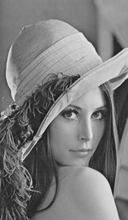

In [3]:
xOffs = 45
img = Image.open("./220px-Lenna_(test_image).png").convert("L")
img = img.crop([xOffs, 0, xOffs+128, img.size[1]])
print(img.size)
imgDat = asarray(img)
img

# Provess sound file

In [4]:
aDat, sRate = sf.read("./AnchorsAweigh.ogg", always_2d=True)
aDat = mean(aDat, 1)
print(sRate, aDat.shape)

11025 (848262,)


In [27]:
#---------------------------
# Overlap save parameters
#---------------------------
N = 2**8                # FFT length (pow. of 2)

M = len(h_f)             # Length of filter repsonse
O = M - 1                # Overlap
L = N - O                # Consumed samples per iteration
print(M, O, N, L)

res = list()
for i, c_t in enumerate(getChunk(aDat, L, O)):
    # Filter = moving, normalized pixel line
    #row = imgDat[(i // 4) % imgDat.shape[0], :].astype("float")
    #row -= min(row)
    #row /= max(row)
    #h_f = hstack((row, zeros(1)))
    
    # Filter = lowpass
    h_f = zeros(N//2+1, dtype=complex)
    h_f[0:2] = 1
    
    c_f = fft.rfft(c_t, N)
    y_f = c_f * h_f
    y_t = fft.irfft(y_f, N)
    res.append(y_t[O:])
res = hstack(res)

129 128 256 128


# Plot filter response

<IPython.core.display.Javascript object>


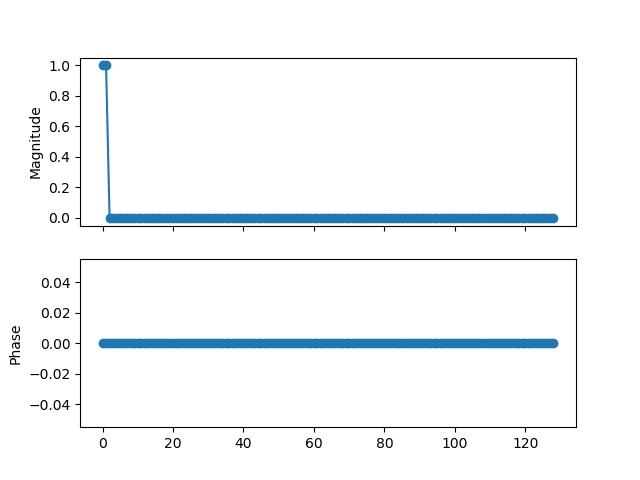

Text(0,0.5,'Phase')

In [28]:
fig, axs = subplots(2, 1, True, False)
axs[0].plot(abs(h_f), "-o")
axs[1].plot(angle(h_f), "-o")
axs[0].set_ylabel("Magnitude")
axs[1].set_ylabel("Phase")

# Play filtered sound

In [8]:
pygame.mixer.pre_init(sRate, size=-16, channels=1)
pygame.mixer.init()

In [26]:
c.stop()

### Filtered

In [29]:
c = pygame.sndarray.make_sound((res * (2**15)).astype(int16)).play()

### Original

In [ ]:
c = pygame.sndarray.make_sound((aDat * (2**15)).astype(int16)).play()

# Plot filtered sound
Why it looks that glitchy??? It's lowpass filtered, should be smooth!


<IPython.core.display.Javascript object>


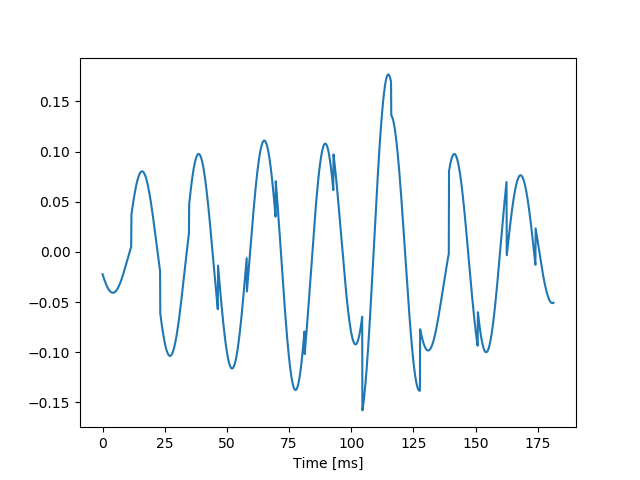

Text(0.5,0,'Time [ms]')

In [35]:
close("all")
plot(arange(2000)/sRate*1000, res[:2000])
xlabel("Time [ms]")